# Attemping Weather Only as ML Input

Attempting an approach where the input is the averaged weather station data 30 mins around the flight departure time.

In [1]:
import sys
# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
sys.path.append(root_path)

# Package to read yml files
import yaml
# Package to handle file paths
import os
# Package to deal with DataFrames
import pandas as pd
# Package to plot stuff
import matplotlib.pyplot as plt
# Package to make nicer plots
import seaborn as sns
# Package for numerical and array handling
import numpy as np
# Package for math stuff
import math
# Package to read and write to .sqlite files
import sqlite3
# Package to keep track of time
import datetime
# Package to decode binary data
import struct
# Package for statistical optimization
import statsmodels.api as sm
# Package for minimization
from scipy.optimize import minimize

# Function to clear output from jupyter notebook
from IPython.display import clear_output
# Package for compressing dataframes into file
from src.data import compressors
# Package for defining and fitting weather models
from src.models import weather
# Utilities package
from src.common import utils
# Package for interpolating and estimating weather
from src.analysis import weather_interpolator
# Package to handle and create plots
from src.frontend import plotter

%matplotlib inline

# Path from this notebook to the root directory
root_path = os.path.normpath(root_path)
# Path from root to the desired config file
config_path_from_root = os.path.normpath('config/config.yml')
# Defining path from this notebook to config file
config_path = os.path.join(root_path, config_path_from_root)

# Loading config file
with open(config_path, 'r',  encoding='utf8') as file:
    config = yaml.safe_load(file)

# Defining "clear-output" function to feed into logger
def clear():
    clear_output(wait=True)

# Creates an instance of a logger class to log all that happens, optional (but encouraged).
logger = utils.Logger(config, clear_function=None)

pltr = plotter.Plotter(config)

# Defining location of data
flights_database = '../data/flight/KSEA_KDEN_2023-01-01_2023-01-31.sqlite'
# flights_database_2 = '../data/flight/KDEN_KSEA_2023-01-01_2023-01-31.sqlite'

weather_database = '../data/weather/Weather-US_2022-12-31_2023-02-01.sqlite'

departure_airport = flights_database.split('/')[-1].split('_')[0]
arrival_airport = flights_database.split('/')[-1].split('_')[1]
month = flights_database.split('/')[-1].split('_')[3].split('-')[1]

flights_thresh = 100

if month == '01':
    month = 'January'
elif month == '07':
    month = 'July'

flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT fs.*,
    fi.*,
    fa.*,
    ofi.time AS opt_time,
    ofi.fuel AS opt_fuel,
    ofi.distance AS opt_distance,
    ofi.wind AS opt_wind,
    ofi.air_density AS opt_air_density,
    ofi.air_pressure AS opt_air_pressure,
    ofi.clouds AS opt_clouds,
    ofi.severity AS opt_severity
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    LEFT JOIN optimal_flights_integrals AS ofi ON ofi.flight_id = fs.flight_id
    """, flights_connection).dropna()

if 'index' in flights.columns:
    flights = flights.drop(['index'], axis='columns')

if 'Unnamed: 0' in flights.columns:
    flights = flights.drop(['Unnamed: 0'], axis='columns')

columns = list(set(list(flights.columns)))

flights = flights[columns]

flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

aircrafts, counts = np.unique(flights['typecode'], return_counts=True)

mask = counts > flights_thresh
aircrafts = aircrafts[mask]
counts = counts[mask]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]

flights['time'] = flights['time'].apply(lambda x: struct.unpack('Q', x)[0])
flights['opt_time'] = flights['opt_time'].apply(lambda x: struct.unpack('Q', x)[0])

flights.drop_duplicates(subset=['flight_id'], inplace=True)

# Finds minimum and maximum flight for current flight
print('Loading time limits.')
min_time, max_time = pd.read_sql_query(f"""
                            SELECT MIN(time) as min_time, MAX(time) as max_time
                            FROM state_vectors 
                            JOIN flights ON flights.flight_id = state_vectors.flight_id
                           """,
                          flights_connection
                          ).values[0]

# Finds the minimum and maximum latitudes for the current flight
print('Loading latitude limits.')
min_latitude, max_latitude = pd.read_sql_query(f"""
                                SELECT MIN(lat) as min_lat, MAX(lat) as max_lat
                                FROM state_vectors 
                                JOIN flights ON flights.flight_id = state_vectors.flight_id
                               """,
                              flights_connection
                              ).values[0]

print('Loading longitude limits.')
# Finds the minimum and maximum longitudes for the current flight
min_longitude, max_longitude = pd.read_sql_query(f"""
                                SELECT MIN(lon) as min_lon, MAX(lon) as max_lon
                                FROM state_vectors 
                                JOIN flights ON flights.flight_id = state_vectors.flight_id
                               """,
                              flights_connection
                              ).values[0]

flights_connection.close()

# Adjusting time, lat and lon thresholds.
print("Adjusting time, lat, lon thresholds.")
# Adds time threshold to time limits
time_thresh = 30*60
min_time -= time_thresh
max_time += time_thresh

lat_lon_thresh = 0.1
# Adds latitude and longitude threshold
range_latitude = max_latitude - min_latitude
range_longitude = max_longitude - min_longitude
min_latitude -= range_latitude*lat_lon_thresh
max_latitude += range_latitude*lat_lon_thresh
min_longitude -= range_longitude*lat_lon_thresh
max_longitude += range_longitude*lat_lon_thresh    

# weather_connection = sqlite3.connect(weather_database)
# # Loads the weather data corresponding to the flight
# print('Loading relevant weather data.')
# weather_data = pd.read_sql_query(f"""
#                                 SELECT wd.*
#                                 FROM weather_data as wd
#                                 JOIN weather_stations as ws ON ws.station_id = wd.station_id
#                                 WHERE wd.time BETWEEN {min_time} AND {max_time};
#                                """,
#                                weather_connection)
# weather_connection.close()

Loading time limits.
Loading latitude limits.
Loading longitude limits.
Adjusting time, lat, lon thresholds.


In [4]:
weather_connection = sqlite3.connect(weather_database)

query = f"""
SELECT ws.*
FROM weather_stations as ws
WHERE ws.lon BETWEEN {min_longitude} AND {max_longitude}
AND ws.lat BETWEEN {min_latitude} AND {max_latitude};
"""
weather_stations_data = pd.read_sql_query(query, weather_connection)

stations = weather_stations_data['station_id'].values
stations

# Convert the list of stations to a format suitable for SQL query
formatted_stations = ', '.join("'" + str(station) + "'" for station in stations)

# SQL query
query = f"""
SELECT * FROM weather_data
WHERE station_id IN ({formatted_stations})
AND time BETWEEN {min_time} AND {max_time};"""

weather_data = pd.read_sql_query(query, weather_connection)

weather_connection.close()

weather_data

,weather_id,station_id,time,tmpf,relh,drct,sknt,sknt_E,sknt_N,p01i,...,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,wx,ice_accretion_1hr,METAR
0,145,05U,1675037400,21.200000,79.310000,10.0,9.0,1.562834,8.863270,0.0,...,None,None,NaN,NaN,NaN,NaN,None,None,NaN,K05U 300010Z AUTO 01009KT 10SM M06/M09 A2984 R...
1,146,05U,1675038600,21.200000,79.310000,20.0,10.0,3.420201,9.396926,0.0,...,None,None,NaN,NaN,NaN,NaN,None,None,NaN,K05U 300030Z AUTO 02010G15KT 10SM M06/M09 A298...
2,147,05U,1675039800,19.400000,79.160000,20.0,8.0,2.736161,7.517541,0.0,...,None,None,NaN,NaN,NaN,NaN,None,None,NaN,K05U 300050Z AUTO 02008KT 10SM M07/M10 A2986 R...
3,148,05U,1675041000,19.400000,79.160000,30.0,8.0,4.000000,6.928203,0.0,...,None,None,NaN,NaN,NaN,NaN,None,None,NaN,K05U 300110Z AUTO 03008KT 10SM M07/M10 A2986 R...
4,149,05U,1675042200,19.400000,79.160000,30.0,6.0,3.000000,5.196152,0.0,...,None,None,NaN,NaN,NaN,NaN,None,None,NaN,K05U 300130Z AUTO 03006KT 10SM M07/M10 A2987 R...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399925,37590603,YKM,1674949200,37.433333,47.334833,20.0,13.0,4.446262,12.216004,0.0,...,0.8,None,4500.0,11000.0,10000.0,NaN,None,None,NaN,KYKM 282340Z AUTO 02013KT 10SM BKN045 BKN110 0...
3399926,37590604,YKM,1674949500,37.266667,47.490667,30.0,15.0,7.500000,12.990381,0.0,...,0.8,None,4500.0,11000.0,10000.0,NaN,None,None,NaN,KYKM 282345Z AUTO 03015KT 10SM BKN045 OVC110 0...
3399927,37590605,YKM,1674949800,37.100000,47.646500,30.0,13.0,6.500000,11.258330,0.0,...,0.8,None,4500.0,11000.0,10000.0,NaN,None,None,NaN,KYKM 282350Z AUTO 03013KT 10SM BKN045 03/M07 A...
3399928,37590606,YKM,1674949980,37.000000,47.740000,40.0,12.0,7.713451,9.192533,0.0,...,0.8,None,4500.0,11000.0,10000.0,NaN,None,None,NaN,KYKM 282353Z AUTO 04012KT 10SM OVC045 03/M07 A...


In [52]:
np.unique(weather_data['wxcodes'].astype('str'))

def numeric_wx(wx):
    bad_codes = ['FC', #funnel clouds (tornados)
                 'DS', #dust storm
                 'SS', #Sandstorm
                 'FZRA', #freezing rain
                 '+SN', #heavy snow
                 'GR', #hail
                 '+RA', #heavy rain
                 'TS', #thunderstorm,
                 'CG', #cloud-ground lightening
                 'IC', #in-cloud lightening
                 'LTG', #lightening,
                 '+FC', #funnel clouds (tornados)
                 '+DS', #dust storm
                 '+SS', #Sandstorm
                 '+FZRA', #freezing rain
                 '+GR', #hail
                 '+TS', #thunderstorm,
                 '+CG', #cloud-ground lightening
                 '+IC', #in-cloud lightening
                 '+LTG', #lightening
                 '-FC', #funnel clouds (tornados)
                 '-DS', #dust storm
                 '-SS', #Sandstorm
                 '-FZRA', #freezing rain
                 '-GR', #hail
                 '-TS', #thunderstorm,
                 '-CG', #cloud-ground lightening
                 '-IC', #in-cloud lightening
                 '-LTG' #lightening
                 ]
    wx = wx.split(' ')
    return float(len(set(wx).intersection(set(bad_codes))) > 0)

def numeric_skyc(skyc):
    if skyc in ['CLR', 'SKC']:
        return 0
    elif skyc == 'FEW':
        return 0.2
    elif skyc == 'SCT':
        return 0.4
    elif skyc == 'BKN':
        return 0.6
    elif skyc == 'OVC':
        return 0.8
    elif skyc == 'VV':
        return 1.0
    else:
        return 0
    
def is_numeric(val):
    try:
        if val is None:
            return False
        if np.isnan(val):
            return False
        float(val)
        return True
    except (ValueError, TypeError):
        return False



print("Fixing wxcodes")
weather_data['wxcodes'] = weather_data['wxcodes'].astype(str).apply(numeric_wx)

print("Fixing skyc")
weather_data['skyc1'] = weather_data['skyc1'].apply(numeric_skyc)
weather_data['skyc2'] = weather_data['skyc2'].apply(numeric_skyc)
weather_data['skyc3'] = weather_data['skyc3'].apply(numeric_skyc)
weather_data['skyc4'] = weather_data['skyc4'].apply(numeric_skyc)

print("Fixing skyl")
weather_data['skyl1'] = weather_data['skyl1'].apply(lambda x: 0.0 if not is_numeric(x) else x)
for col in ['skyl2', 'skyl3', 'skyl4']:
    prev_col = weather_data.columns[weather_data.columns.get_loc(col) - 1]
    weather_data[col] = weather_data.apply(lambda row: row[prev_col] if not is_numeric(row[col]) else row[col], axis=1)

print("Fixing ice_accretion_1hr")
weather_data['ice_accretion_1hr'] = weather_data['ice_accretion_1hr'].apply(lambda x: 0 if (x is None or np.isnan(x)) else x)

columns = ['station_id', 'time', 'tmpf', 'relh', 'drct', 'sknt',
       'sknt_E', 'sknt_N', 'p01i', 'skyc1', 'skyc2', 'skyc3', 'skyc4', 'skyl1',
       'skyl2', 'skyl3', 'skyl4', 'wxcodes', 'ice_accretion_1hr']

weather_data = weather_data[columns]

Fixing wxcodes
Fixing skyc
Fixing skyl
Fixing ice_accretion_1hr


In [130]:
def sigmoid(x_arr):
    x_mean = np.mean(x_arr)
    x_std = np.std(x_arr)
    if x_std == 0:
        x_std = 1
    return 1/(1+np.exp(-(x_arr - x_mean)/x_std))

all_stations = weather_data['station_id'].unique()
columns = ['tmpf', 'relh', 'drct', 'sknt', 'sknt_E', 'sknt_N', 'p01i', 'skyc1', 'skyc2', 'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3', 'skyl4', 'wxcodes', 'ice_accretion_1hr']

y = np.zeros(len(flights))
X = np.zeros((len(flights), len(all_stations)*len(columns)))

flights.index = range(len(flights))

for idx, flight in flights.iterrows():
    clear_output(wait=True)
    print(f"{idx}/{len(flights)}")
    y[idx] = flight['fuel']
    
    result_df = pd.DataFrame(0, index=all_stations, columns=columns)
    time = int(flight['firstseen'])
    time_mask = abs(weather_data['time'] - time) < 60*30
    weather_data_flight = weather_data[time_mask]

    if len(weather_data_flight) > 0:
        average_data = weather_data_flight.groupby('station_id').mean().fillna(0)
        # Updating the result DataFrame with the calculated averages
        result_df.update(average_data)
        data = np.ravel(result_df.values)
        X[idx,:] = data
    
y = sigmoid(y)
X = np.array([sigmoid(x) for x in X.T]).T

160/161


In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import kstest
import scipy.stats as stats
from sklearn.model_selection import learning_curve


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


R-squared: -0.11613200527094736
Mean Squared Error: 0.037879886055751044
KS Statistic: 0.12121212121212122
P-value: 0.9725172787255439


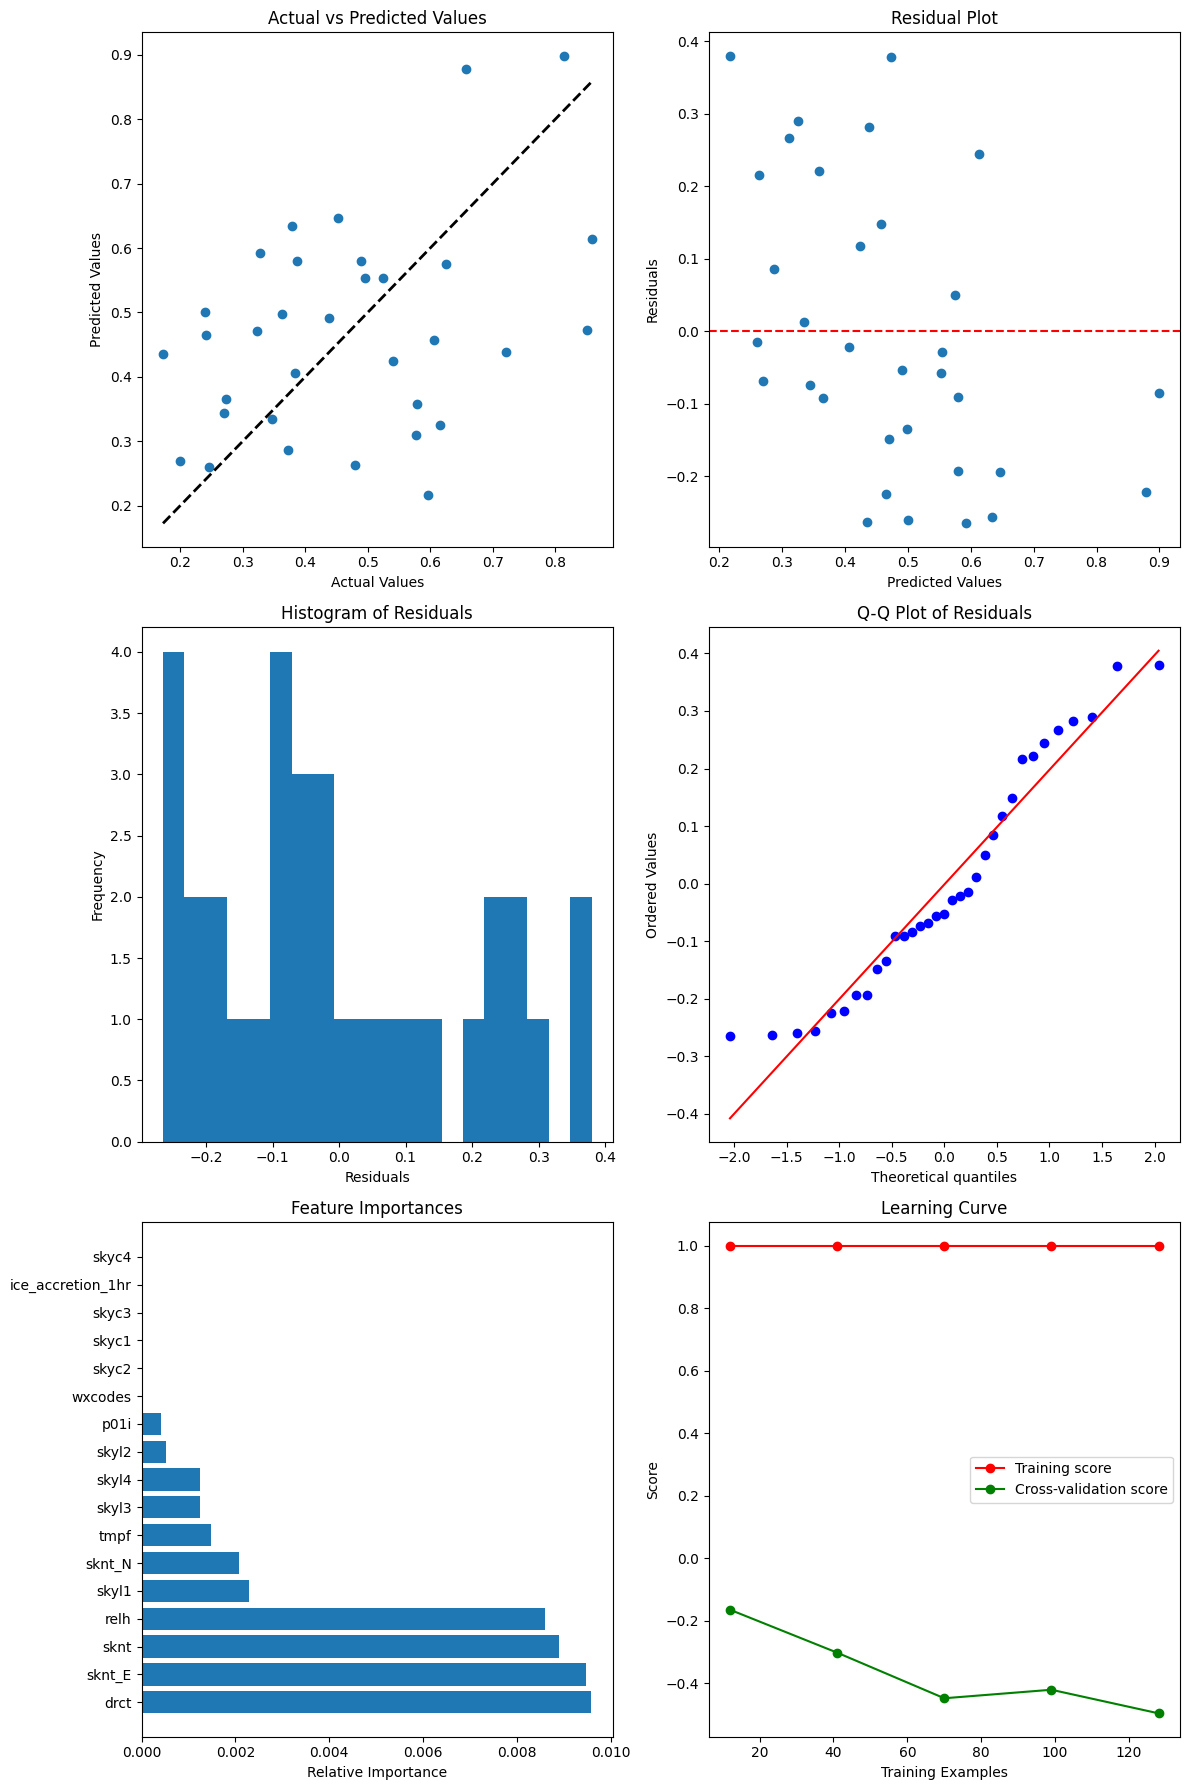

In [132]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(3, 2, figsize = [2*6, 3*6])

# Initializing model
model = LinearRegression()

# Training model
model.fit(X_train, y_train)

# Makeing predictions
y_pred = model.predict(X_test)

# Computing statistical metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = kstest(y_test, y_pred)

# Assuming model.coef_ contains an array of coefficients from a trained model
coefficients = model.coef_

coefficients = abs(coefficients)

# Pair up feature names with their corresponding coefficients
features_and_coefficients = list(zip(columns, coefficients))

# Sort the features and their coefficients by the absolute values of the coefficients
sorted_features_and_coefficients = sorted(features_and_coefficients, key=lambda x: np.abs(x[1]), reverse=True)

# Unzip into separate lists
sorted_features, sorted_coefficients = zip(*sorted_features_and_coefficients)

# Computing residuals
residuals = y_test - y_pred

# Computing learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, train_sizes=np.linspace(.1, 1.0, 5), cv=5)

# Computing mean scores for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Print metrics
print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')

# Print KS statistic
print(f'KS Statistic: {ks_statistic}')
print(f'P-value: {p_value}')

ax[0, 0].scatter(y_test, y_pred)
ax[0, 0].set_title('Actual vs Predicted Values')
ax[0, 0].set_xlabel('Actual Values')
ax[0, 0].set_ylabel('Predicted Values')
ax[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line

ax[0, 1].scatter(y_pred, residuals)
ax[0, 1].set_title('Residual Plot')
ax[0, 1].set_xlabel('Predicted Values')
ax[0, 1].set_ylabel('Residuals')
ax[0, 1].axhline(y=0, color='red', linestyle='--')

ax[1, 0].hist(residuals, bins=20)
ax[1, 0].set_title('Histogram of Residuals')
ax[1, 0].set_xlabel('Residuals')
ax[1, 0].set_ylabel('Frequency')

stats.probplot(residuals, dist="norm", plot=ax[1, 1])
ax[1, 1].set_title('Q-Q Plot of Residuals')

ax[2, 0].set_title('Feature Importances')
ax[2, 0].barh(sorted_features, sorted_coefficients)
ax[2, 0].set_yticks(range(len(sorted_features)), sorted_features)
ax[2, 0].set_xlabel('Relative Importance')

ax[2, 1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[2, 1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[2, 1].set_title('Learning Curve')
ax[2, 1].set_xlabel('Training Examples')
ax[2, 1].set_ylabel('Score')
ax[2, 1].legend(loc="best")

fig.tight_layout()


R-squared: -0.7882924962480218
Mean Squared Error: 0.06069202896460738
KS Statistic: 0.12121212121212122
P-value: 0.9725172787255439


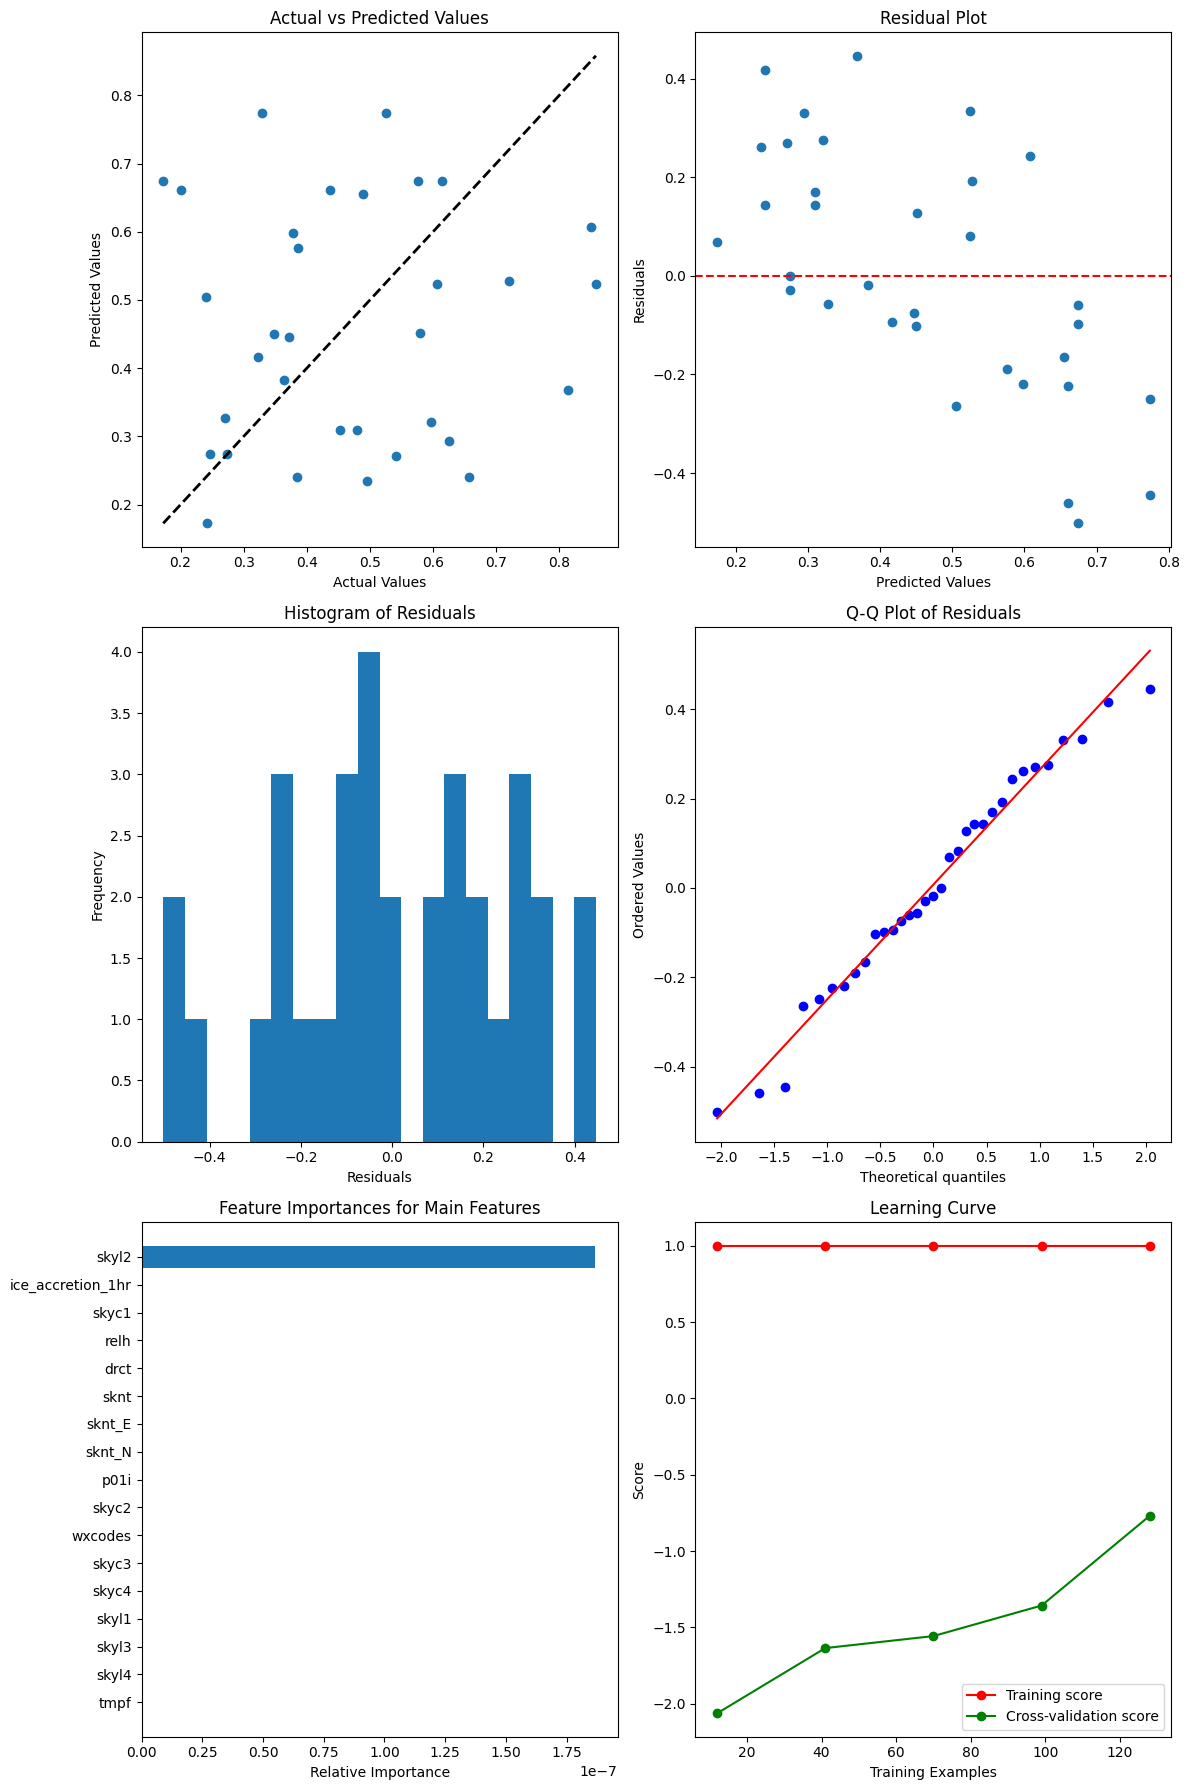

In [133]:
from sklearn.tree import DecisionTreeRegressor

fig, ax = plt.subplots(3, 2, figsize = [2*6, 3*6])

# Initializing model
model = DecisionTreeRegressor()

# Training model
model.fit(X_train, y_train)

# Makeing predictions
y_pred = model.predict(X_test)

# Computing statistical metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = kstest(y_test, y_pred)

# Importance of each feature
importances = model.feature_importances_

# Create a dictionary mapping feature names to their importances
feature_importances_dict = dict(zip(columns, importances))

# Extract the importances for the main features
main_importances = [feature_importances_dict[column] for column in columns]

# Sort the main features by their importance
sorted_idx_main = np.argsort(main_importances)

# Computing residuals
residuals = y_test - y_pred

# Computing learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, train_sizes=np.linspace(.1, 1.0, 5), cv=5)

# Computing mean scores for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Print metrics
print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')

# Print KS statistic
print(f'KS Statistic: {ks_statistic}')
print(f'P-value: {p_value}')

ax[0, 0].scatter(y_test, y_pred)
ax[0, 0].set_title('Actual vs Predicted Values')
ax[0, 0].set_xlabel('Actual Values')
ax[0, 0].set_ylabel('Predicted Values')
ax[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line

ax[0, 1].scatter(y_pred, residuals)
ax[0, 1].set_title('Residual Plot')
ax[0, 1].set_xlabel('Predicted Values')
ax[0, 1].set_ylabel('Residuals')
ax[0, 1].axhline(y=0, color='red', linestyle='--')

ax[1, 0].hist(residuals, bins=20)
ax[1, 0].set_title('Histogram of Residuals')
ax[1, 0].set_xlabel('Residuals')
ax[1, 0].set_ylabel('Frequency')

stats.probplot(residuals, dist="norm", plot=ax[1, 1])
ax[1, 1].set_title('Q-Q Plot of Residuals')

ax[2, 0].set_title('Feature Importances for Main Features')
ax[2, 0].barh(range(len(sorted_idx_main)), np.array(main_importances)[sorted_idx_main], align='center')
ax[2, 0].set_yticks(range(len(sorted_idx_main)), np.array(columns)[sorted_idx_main])
ax[2, 0].set_xlabel('Relative Importance')

ax[2, 1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[2, 1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[2, 1].set_title('Learning Curve')
ax[2, 1].set_xlabel('Training Examples')
ax[2, 1].set_ylabel('Score')
ax[2, 1].legend(loc="best")
    
fig.tight_layout()


R-squared: -0.10322379408458149
Mean Squared Error: 0.0374418002678568
KS Statistic: 0.3939393939393939
P-value: 0.011264373743090028


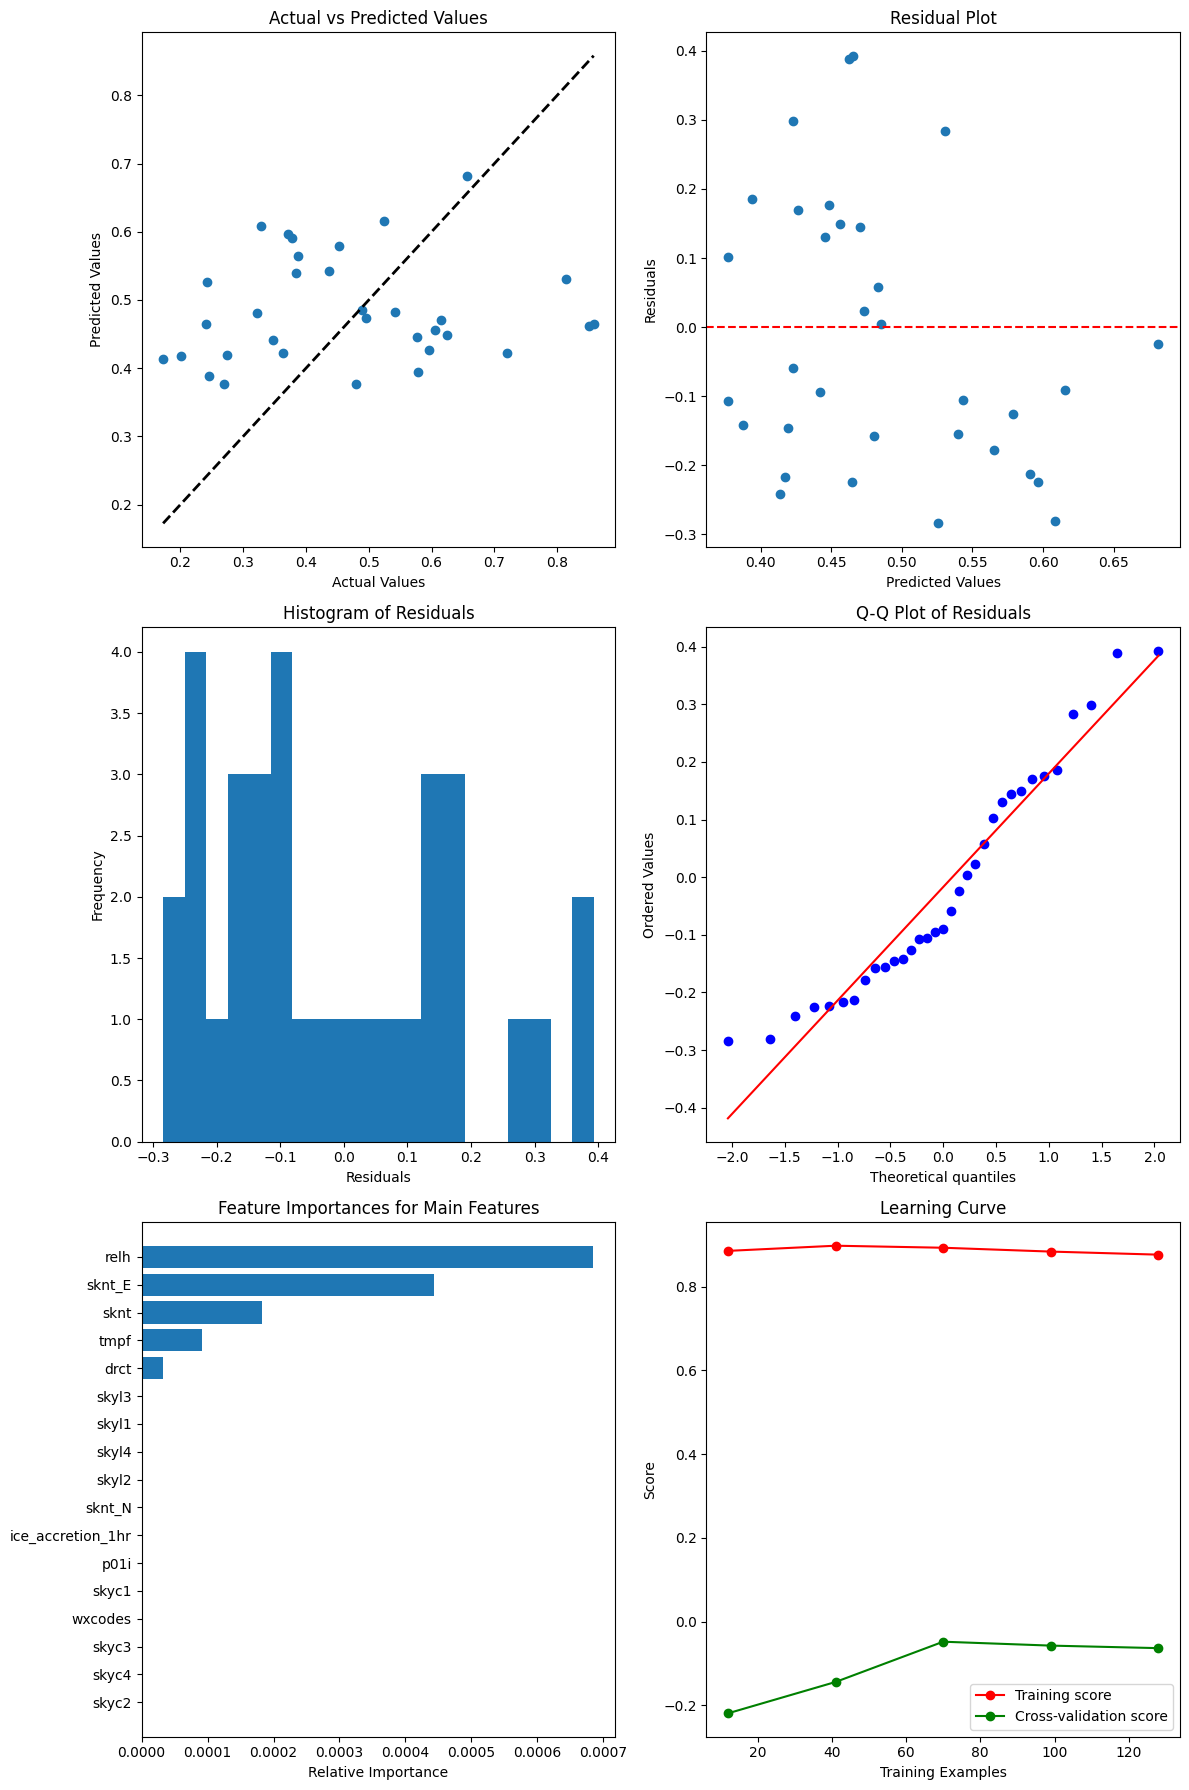

In [134]:
from sklearn.ensemble import RandomForestRegressor

fig, ax = plt.subplots(3, 2, figsize = [2*6, 3*6])

# Initializing model
model = RandomForestRegressor()

# Training model
model.fit(X_train, y_train)

# Makeing predictions
y_pred = model.predict(X_test)

# Computing statistical metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = kstest(y_test, y_pred)

# Importance of each feature
importances = model.feature_importances_

# Create a dictionary mapping feature names to their importances
feature_importances_dict = dict(zip(columns, importances))

# Extract the importances for the main features
main_importances = [feature_importances_dict[column] for column in columns]

# Sort the main features by their importance
sorted_idx_main = np.argsort(main_importances)

# Computing residuals
residuals = y_test - y_pred

# Computing learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, train_sizes=np.linspace(.1, 1.0, 5), cv=5)

# Computing mean scores for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Print metrics
print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')

# Print KS statistic
print(f'KS Statistic: {ks_statistic}')
print(f'P-value: {p_value}')

ax[0, 0].scatter(y_test, y_pred)
ax[0, 0].set_title('Actual vs Predicted Values')
ax[0, 0].set_xlabel('Actual Values')
ax[0, 0].set_ylabel('Predicted Values')
ax[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line

ax[0, 1].scatter(y_pred, residuals)
ax[0, 1].set_title('Residual Plot')
ax[0, 1].set_xlabel('Predicted Values')
ax[0, 1].set_ylabel('Residuals')
ax[0, 1].axhline(y=0, color='red', linestyle='--')

ax[1, 0].hist(residuals, bins=20)
ax[1, 0].set_title('Histogram of Residuals')
ax[1, 0].set_xlabel('Residuals')
ax[1, 0].set_ylabel('Frequency')

stats.probplot(residuals, dist="norm", plot=ax[1, 1])
ax[1, 1].set_title('Q-Q Plot of Residuals')

ax[2, 0].set_title('Feature Importances for Main Features')
ax[2, 0].barh(range(len(sorted_idx_main)), np.array(main_importances)[sorted_idx_main], align='center')
ax[2, 0].set_yticks(range(len(sorted_idx_main)), np.array(columns)[sorted_idx_main])
ax[2, 0].set_xlabel('Relative Importance')

ax[2, 1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[2, 1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[2, 1].set_title('Learning Curve')
ax[2, 1].set_xlabel('Training Examples')
ax[2, 1].set_ylabel('Score')
ax[2, 1].legend(loc="best")

fig.tight_layout()